In [1]:
# how do aggregated differ across time and space
# aggregates have regions of dead and alive cells - a couple images to show that - showed
# aggregates are made up of multiple nuclei - image to show that. python or something - showed
# aggregate composition may be different across different treatement types and times...across
# across time and treatment type nuclei may be of different intensities, distributed across the cells

# Are these linear relationships or not 
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import tiffile as tiff
import glob
import re
import random
import networkx as nx
from skimage.measure import label,regionprops
from skimage.feature import SIFT as sift
from sklearn.decomposition import NMF
from astropy.visualization import hist as histo
from scipy.spatial.distance import squareform,pdist,cdist
from scipy.ndimage._morphology import distance_transform_cdt as dist_form
from scipy.ndimage import sobel
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf
from scipy.spatial import distance,Delaunay, KDTree
import itertools
import seaborn as sns
import scipy.stats
import napari

def draw_grid(image, line_space=20):
    H, W = image.shape
    image[0:H:line_space] = 1
    image[:, 0:W:line_space] = 1
    
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))
def entropy(binary_image):
    cancer_cells = np.sum(binary_image * 1)
    col_divided = blockshaped(binary_image,100,100)
    
    list_of_entropies = []
    
    for instance in col_divided:
        number_of_cells = np.sum(instance * 1)
        #print(number_of_cells)
        if number_of_cells != 0:
            small_n = np.sum(number_of_cells * 1)
            ent_time = small_n / cancer_cells
            frame = ent_time * np.log(ent_time)
            list_of_entropies.append(-frame)
        else:
            list_of_entropies.append(0)
    return(list_of_entropies)
    
def pixel_val_entropy(image,scale):
    entropy_holder = 0
    vals,counts = np.unique(image,return_counts=True)
    for val,con in zip(vals,counts):
        pie = con/(scale * scale)
        bit = pie * np.log(pie)
        entropy_holder = entropy_holder - bit
    return(entropy_holder)
    
def r2(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)
     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    correlation = np.corrcoef(x, y)[0,1]

     # r
    results['correlation'] = correlation
     # r-squared
    results['determination'] = correlation**2

    return results
    
def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))
    
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def decile(var):
    deciles = np.percentile(var, np.arange(10, 100, 10))
    return(deciles)

def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def get_centroids(mask):
    objects, inverts, counts = np.unique(mask, return_counts=True, return_inverse=True)
    
    # Reduction by object
    x = np.full(len(objects), 0.0)
    y = np.full(len(objects), 0.0)
    xPos = np.repeat(np.arange(mask.shape[0]), mask.shape[1])
    yPos = np.tile(np.arange(mask.shape[1]), reps=mask.shape[0])
    np.add.at(x, inverts, xPos)
    np.add.at(y, inverts, yPos)
    
    # Compute the final mean from the sum
    x /= counts
    y /= counts
    
    # Discard the first item (when obj == 0)
    x = x[1:]
    y = y[1:]
    return np.array([x,y]).T
    
def to_networkx(d_triangle):
    G = nx.Graph()
    for path in d_triangle.simplices:
        nx.add_path(G, path)
    return G

def frechet_dist(exp_data, num_data, p=2):
    r"""
    Compute the discrete Frechet distance

    Compute the Discrete Frechet Distance between two N-D curves according to
    [1]_. The Frechet distance has been defined as the walking dog problem.
    From Wikipedia: "In mathematics, the Frechet distance is a measure of
    similarity between curves that takes into account the location and
    ordering of the points along the curves. It is named after Maurice Frechet.
    https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance

    Parameters
    ----------
    exp_data : array_like
        Curve from your experimental data. exp_data is of (M, N) shape, where
        M is the number of data points, and N is the number of dimmensions
    num_data : array_like
        Curve from your numerical data. num_data is of (P, N) shape, where P
        is the number of data points, and N is the number of dimmensions
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.

    Returns
    -------
    df : float
        discrete Frechet distance

    References
    ----------
    .. [1] Thomas Eiter and Heikki Mannila. Computing discrete Frechet
        distance. Technical report, 1994.
        http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.90.937&rep=rep1&type=pdf

    Notes
    -----
    Your x locations of data points should be exp_data[:, 0], and the y
    locations of the data points should be exp_data[:, 1]. Same for num_data.

    Thanks to Arbel Amir for the issue, and Sen ZHANG for the iterative code
    https://github.com/cjekel/similarity_measures/issues/6

    Examples
    --------
    >>> # Generate random experimental data
    >>> x = np.random.random(100)
    >>> y = np.random.random(100)
    >>> exp_data = np.zeros((100, 2))
    >>> exp_data[:, 0] = x
    >>> exp_data[:, 1] = y
    >>> # Generate random numerical data
    >>> x = np.random.random(100)
    >>> y = np.random.random(100)
    >>> num_data = np.zeros((100, 2))
    >>> num_data[:, 0] = x
    >>> num_data[:, 1] = y
    >>> df = frechet_dist(exp_data, num_data)

    """
    n = len(exp_data)
    m = len(num_data)
    c = cdist(exp_data, num_data, metric='minkowski', p=p)
    ca = np.ones((n, m))
    ca = np.multiply(ca, -1)
    ca[0, 0] = c[0, 0]
    for i in range(1, n):
        ca[i, 0] = max(ca[i-1, 0], c[i, 0])
    for j in range(1, m):
        ca[0, j] = max(ca[0, j-1], c[0, j])
    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = max(min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1]),
                           c[i, j])
    return ca[n-1, m-1]


pixel_thresh = 3.5
lop_off_inteval = 116

In [2]:
import pandas as pd

In [3]:
rasa_slider = []

high_et = ['B','D','F','H','J']
for i in range(2,14,2):
    rasas = [str(i)]
    combos = list(itertools.product(high_et, rasas))
    newlist = ["".join(item) for item in combos ]
    rasa_slider.append(newlist)

print(rasa_slider)

low_high_rasa = [rasa_slider[1],rasa_slider[-2]]
print("bleeba")

[['B2', 'D2', 'F2', 'H2', 'J2'], ['B4', 'D4', 'F4', 'H4', 'J4'], ['B6', 'D6', 'F6', 'H6', 'J6'], ['B8', 'D8', 'F8', 'H8', 'J8'], ['B10', 'D10', 'F10', 'H10', 'J10'], ['B12', 'D12', 'F12', 'H12', 'J12']]
bleeba


In [12]:
low_high_rasa

[['B4', 'D4', 'F4', 'H4', 'J4'], ['B10', 'D10', 'F10', 'H10', 'J10']]

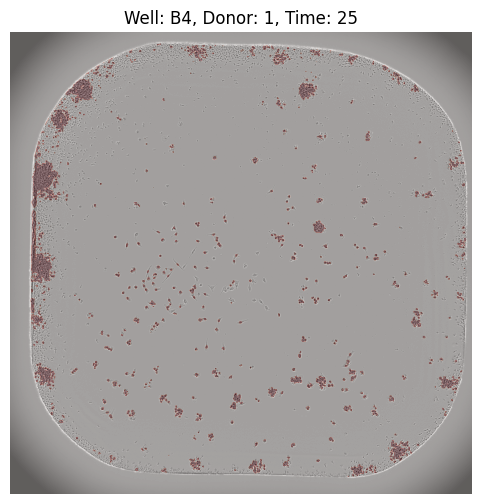

In [33]:
def plot_representative_fn(well_id, donor_id, time_point, trim=100, lab_folder_path='/gladstone/engelhardt/lab/', save_path=None):
    '''
    Given a well id, donor id, and time point, plot the representative bright field + RFP image
    '''
    # create a list of all the image file paths that correspond to this donor_id
    donor_location_phase = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/phase_registered/*tif".format(donor_id)
    donor_location_red = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/red_registered/*tif".format(donor_id)
    files_phase = glob.glob(donor_location_phase)
    files_red = glob.glob(donor_location_red)

    # find the list of file paths that correspond to the specified well_id
    # store all image paths from this well in a list, sorted by timepoint
    #phase
    matching = [s for s in files_phase if (well_id + "_") in s]
    sorted_file_list_phase = (sorted_nicely(matching))
    # #red
    matching = [s for s in files_red if (well_id + "_") in s]
    sorted_file_list_red = (sorted_nicely(matching))

    # subset the list to the specified time point and load the images
    resized_latish_phase = tiff.imread(sorted_file_list_phase[time_point])
    resized_latish_red = tiff.imread(sorted_file_list_red[time_point])
    # threshold the red channel into a binary mask
    red_frame = resized_latish_red > 3.5

    # normalize intensity of the phase image
    phase_frame = cv.normalize(resized_latish_phase, None, 0, 255, cv.NORM_MINMAX).astype('uint8') 

    # plot the phase image with the red mask superimposed
    plt.figure(figsize=(6,6))
    trim=100
    plt.imshow(red_frame[trim:-trim,trim:-trim], cmap='Reds', alpha = 1.0)
    plt.imshow(phase_frame[trim:-trim,trim:-trim], cmap='gray', alpha = .75)
    plt.title('Well: {}, Donor: {}, Time: {}'.format(well_id,donor_id,time_point), size = 12)
    # remove the axes ticks and labels
    plt.axis('off')

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return


plot_representative_fn(well_id='B4', donor_id=1, time_point=25, save_path='saft_figuren/figures/B4_donor1_time25.pdf')

In [31]:
import os
os.getcwd()

'/gladstone/engelhardt/lab/adamw'

/gladstone/engelhardt/lab/MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor1/phase_registered/*tif
B4 1 67


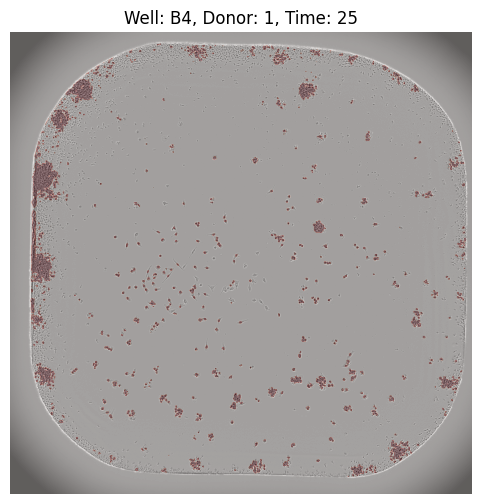

ValueError: stop here

In [24]:
# list_of_graphs = []
# an update from jan 12th; some of the statistics such as nuclei number and area are weighted by the size of the aggregate they are in
# I believe that smaller aggregates are being weighed more than bigger ones 
#ultimately the unweighting makes this trend more pronounced...I should compare weighted vs un weighted over time....esp the raw difference
# interested in how this gerrymandering sort of plays out
thresh_ar = np.array(list(range(7,40,7)))/2

aggregate_mass = []
aggre_puncs = []
rasa_marker = []
punc_mass = []
time_list = []#
donor_list = []
mean_blobtensity = []
total_mass = []
total_number = []
frame_high_fluor = []
puncts_ar = []
threshs_ar = []
pareas_ar = []
rasa_diff_ar = []#
donor_ar = []
key_ar = []
descriptor_ar = []
area_list = []
name_list = [] 
scales_ar = []
frame_entropy = []

# set the appropriate lab folder path based on the location of the data
# lab_folder_path = '/Volumes/Engelhardt-Lab/'
lab_folder_path = '/gladstone/engelhardt/lab/'

for donor_number in range(1,5):
    donor_location_phase = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/phase_registered/*tif".format(donor_number)
    donor_location_red = lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor{}/red_registered/*tif".format(donor_number)

    print(donor_location_phase)
    files_phase = glob.glob(donor_location_phase)
    files_red = glob.glob(donor_location_red)

    rasa_status = 0
    for rasa_selection in low_high_rasa:
        for sliding_rasa in rasa_selection:

            #phase
            matching = [s for s in files_phase if (sliding_rasa + "_") in s]
            sorted_file_list_phase = (sorted_nicely(matching))
            # #red
            matching = [s for s in files_red if (sliding_rasa + "_") in s]
            sorted_file_list_red = (sorted_nicely(matching))
            print(sliding_rasa,donor_number,len(sorted_file_list_red))

            # loop through the time points
            max_times = len(sorted_file_list_phase)
            tc = 0
            for indice in range(0,max_times):
                if tc == 25:
                    resized_latish_phase = tiff.imread(sorted_file_list_phase[indice])
                    resized_latish_red = tiff.imread(sorted_file_list_red[indice])
                    aggregate_threshed = resized_latish_red > 3.5
                    time_list.append(tc)
                    rasa_diff_ar.append(rasa_status)
                                    
                    
                    phase_frame = cv.normalize(resized_latish_phase, None, 0, 255, cv.NORM_MINMAX).astype('uint8') 

                    red_frame = aggregate_threshed#[indice,:,:]
                    red_resized = red_frame[16:-16,16:-16]
                    red_entropy = np.sum(entropy(red_resized))
                    #red_frame_labeled = label(red_frame)

                    # plot the phase image with the red_frame superimposed
                    plt.figure(figsize=(6,6))
                    trim=100
                    plt.imshow(red_frame[trim:-trim,trim:-trim], cmap='Reds', alpha = 1.0)
                    plt.imshow(phase_frame[trim:-trim,trim:-trim], cmap='gray', alpha = .75)
                    plt.title('Well: {}, Donor: {}, Time: {}'.format(sliding_rasa,donor_number,tc), size = 12)
                    # remove the axes ticks and labels
                    plt.axis('off')
                    plt.show()
                    
                    raise ValueError("stop here")


                    descriptor_extractor = sift()
                    descriptor_extractor.detect_and_extract(phase_frame)
                    keypoints1 = descriptor_extractor.keypoints
                    descriptors1 = descriptor_extractor.descriptors
                    #scales1 = descriptor_extractor.scales
                    scales1 = descriptor_extractor.octaves

                    key_ar.append(keypoints1)#[to_append])
                    descriptor_ar.append(descriptors1)#[to_append])
                    scales_ar.append(scales1)
                    donor_ar.append(donor_number)
                    frame_entropy.append(red_entropy)
                    name_list.append(sorted_file_list_phase[indice])
                    pareas_ar.append(np.sum((red_frame * 1).ravel()))

                tc = tc + 1
            rasa_status = rasa_status + 1
    
                # in the future you can do depth first search, point intensity of the unique point values 
                # append graphs for a lot of images
                # look at approximated graph edit distance per the turkish paper and compute that
print("Done")

In [ ]:

subloc = []
subgrad = []
subscale = []
time_holder = []
rasa_holder = []
donor_holder = []
name_holder = []
npix_cancer = []
entropy_holder = []
#sift_features = np.concatenate( descriptor_ar, axis=0 )
for i in range(0,len(descriptor_ar)):
    current_time = time_list[i]
    current_rasa = rasa_diff_ar[i]
    current_donor = donor_ar[i]
    current_name = name_list[i]
    current_cancer = pareas_ar[i]
    current_entropy = frame_entropy[i]
    n, m = descriptor_ar[i].shape
    
    sub_sift = descriptor_ar[i]#[idx,:]
    key_ar_sub = key_ar[i]#[idx,:]
    sub_scale = scales_ar[i]
    
    subgrad.extend(sub_sift)
    subloc.extend(key_ar_sub)
    subscale.extend(sub_scale)
    entropy_holder.extend([current_entropy] * n)
    npix_cancer.extend([current_cancer] * n)
    time_holder.extend([current_time] * n)
    rasa_holder.extend([current_rasa] * n)
    donor_holder.extend([current_donor] * n)
    name_holder.extend([current_name]* n)

sublist_ar = np.array(subgrad)
print("Finito")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
scaler = StandardScaler()
pca1 = PCA().fit(sublist_ar)
X=sublist_ar
scaler.fit(X)
X=scaler.transform(X)    
pca = PCA(n_components=30)
x_new = pca.fit_transform(X)



In [ ]:
k = 6
kmeans = KMeans(n_clusters=k).fit(sublist_ar)
lab_arr = np.array(kmeans.labels_)

plt.scatter(x_new[:,0],x_new[:,1], c = lab_arr, alpha = .01,s = .1)
#healthy confluent
#edge effect 2
#circular cells 
#unhealthy confluent
#edge effect 1

In [ ]:
plt.scatter(x_new[:,2],x_new[:,1], c = lab_arr, alpha = .01,s = .1)


In [ ]:
plt.scatter(x_new[:,2],x_new[:,0], c = lab_arr, alpha = .01,s = .1)


In [ ]:
plt.scatter(x_new[:,7],x_new[:,8], c = lab_arr, alpha = .01,s = .1)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

img_centroid = [616.0, 616.0]#[img_read.shape[0]/2,img_read.shape[0]/2]
imcent = np.expand_dims(img_centroid,0)
locs_transformed = cdist(subloc,imcent)




for i in range(0,6):
    print(i)
    reducer = umap.UMAP()
    idx = np.random.randint(0,x_new[ddi][(lab_arr[ddi] == 0) | (lab_arr[ddi] == 5) | (lab_arr[ddi] == 1) |  (lab_arr[ddi] == 3)].shape[0],800000)
    embedding = reducer.fit_transform(X[ddi][(lab_arr[ddi] == 0) |(lab_arr[ddi] == 5) | (lab_arr[ddi] == 1) |  (lab_arr[ddi] == 3)][idx,:])
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=np.array(lab_arr)[ddi][(lab_arr[ddi] == 0) | (lab_arr[ddi] == 5) | (lab_arr[ddi] == 1) |  (lab_arr[ddi] == 3)][idx],
        s =2,
        alpha=.1)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the SIFT class {}'.format(i), fontsize=24)
    plt.savefig("figures/umap_class_{}.png".format(i))
    plt.close()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

# homog_l = []
# contrast_l = []
# correl_l = []
# energy_l = []

img_centroid = [616.0, 616.0]#[img_read.shape[0]/2,img_read.shape[0]/2]
imcent = np.expand_dims(img_centroid,0)
locs_transformed = cdist(subloc,imcent)

for donor in range(1,5):
    print(donor)

    ddi = np.where(np.array(donor_holder) == donor)
    
    rndm_points = 200000
    
    reducer = umap.UMAP()
    idx = np.random.randint(0,x_new[ddi,:1].shape[0],rndm_points)
    embedding = reducer.fit_transform(x_new[ddi,:15][idx,:])
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=(np.array(lab_arr)[ddi][idx]),
        s =2,
        alpha=.1)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection \n of {} random points'.format(rndm_points), fontsize=24)
    plt.savefig("figures/umap_POINTS_{}_donor{}.png".format(rndm_points,donor))
    plt.close()


In [ ]:
for donor in range(1,):
    print(donor)

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=np.array(homog_l)[ddi][idx],
    s =2,
    alpha=.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SIFT class {}'.format(i), fontsize=24)
plt.savefig("figures/umap_homog.png".format(i))
plt.close()

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=np.array(energy_l)[ddi][idx],
    s =2,
    alpha=.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SIFT class {}'.format(i), fontsize=24)
plt.savefig("figures/umap_energy.png".format(i))
plt.close()

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=np.array(contrast_l)[ddi][idx],
    s =2,
    alpha=.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SIFT class {}'.format(i), fontsize=24)
plt.savefig("figures/umap_contrast.png".format(i))
plt.close()

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=np.array(correl_l)[ddi][idx],
    s =2,
    alpha=.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SIFT class {}'.format(i), fontsize=24)
plt.savefig("figures/umap_correl.png".format(i))
plt.close()

In [ ]:
framb_ar = np.array(frame_holder)# = []
class_arb = np.array(class_holder)# = []
rfpb_ar  = np.array(rfp_signal_normalize)# = []
rasa_holder1_ar = np.array(rasa_holder1)

two_class = 1
third_class = 5

hi_r = rasa_holder1_ar < 5
lo_r = rasa_holder1_ar > 5
twoend_class = class_arb == two_class
thirdend_class = class_arb == third_class

interval_holder2 = []
interval_holder3 = []

fig,ax = plt.subplots(1,2)
for frame_val in np.unique(framb_ar):
    
    current_frame = framb_ar == frame_val
    
    tword_rfp_val = rfpb_ar[twoend_class & current_frame & hi_r]
    third_rfp_val = rfpb_ar[thirdend_class & current_frame & hi_r]

    
    mean0, blb0, bub0 = mean_confidence_interval(tword_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder2.append(interval0)

    
    mean0, blb0, bub0 = mean_confidence_interval(third_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder3.append(interval0)


interval_holder2 = np.array(interval_holder2)
interval_holder3 = np.array(interval_holder3)




ax[0].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder2[:,1],interval_holder2[:,2],alpha =.2,label = "Cluster {}".format(two_class))# 100
ax[0].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder3[:,1],interval_holder3[:,2],alpha = .2,label = "Cluster {}".format(third_class))# 100
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Cancer nuclear pixels in ROI")
ax[0].set_title("high_rasa")

interval_holder2 = []
interval_holder3 = []

for frame_val in np.unique(framb_ar):
    
    current_frame = framb_ar == frame_val
    
    tword_rfp_val = rfpb_ar[twoend_class & current_frame & lo_r]
    third_rfp_val = rfpb_ar[thirdend_class & current_frame & lo_r]

    
    mean0, blb0, bub0 = mean_confidence_interval(tword_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder2.append(interval0)

    
    mean0, blb0, bub0 = mean_confidence_interval(third_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder3.append(interval0)


interval_holder2 = np.array(interval_holder2)
interval_holder3 = np.array(interval_holder3)




ax[1].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder2[:,1],interval_holder2[:,2],alpha =.2,label = "Cluster {}".format(two_class))# 100
ax[1].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder3[:,1],interval_holder3[:,2],alpha = .2,label = "Cluster {}".format(third_class))# 100
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Cancer nuclear pixels in ROI")
ax[1].set_title("Low rasa")
plt.legend()

In [ ]:
import matplotlib as mpl

leg_et = [2.824,2.000,1.4142,1.0000,0.7071]


jet = mpl.colormaps['plasma'].resampled(5)
newcolors = jet(np.linspace(0, 1, 5))


framb_ar = np.array(frame_holder)# = []
class_arb = np.array(class_holder)# = []
rfpb_ar  = np.array(rfp_signal_normalize)# = []

fig,ax = plt.subplots(1,2)


for e_t in np.unique(rasa_holder1_ar[hi_r]):
    e_t_selected = rasa_holder1_ar == e_t
    interval_holder2 = []
    interval_holder3 = []

    for frame_val in np.unique(framb_ar):
        
        current_frame = framb_ar == frame_val
        
        tword_rfp_val = rfpb_ar[twoend_class & current_frame & hi_r & e_t_selected]
        third_rfp_val = rfpb_ar[thirdend_class & current_frame & hi_r& e_t_selected]
    
        
        mean0, blb0, bub0 = mean_confidence_interval(tword_rfp_val, confidence=0.95)
        interval0 = [mean0, blb0, bub0]
        interval_holder2.append(interval0)
    
        
        mean0, blb0, bub0 = mean_confidence_interval(third_rfp_val, confidence=0.95)
        interval0 = [mean0, blb0, bub0]
        interval_holder3.append(interval0)
    
    
    interval_holder2 = np.array(interval_holder2)
    interval_holder3 = np.array(interval_holder3)
        
    
    
    
    ax[0].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder2[:,1],interval_holder2[:,2],alpha =.2,label = "Cluster {}".format(two_class),color=newcolors[e_t -5])# 100
    ax[1].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder3[:,1],interval_holder3[:,2],alpha = .2,label = "E:T ratio: {}".format(leg_et[e_t]),color=newcolors[e_t])# 100
ax[0].set_xlabel("Time")
ax[0].set_ylabel("RFP mean pixel intensity in ROI")
ax[0].set_title("Cluster #{}".format(two_class))
ax[1].set_title("Cluster #{}".format(third_class))
ax[1].legend()
plt.suptitle("E:T ratio difference in HIGH RASA2KO coculture")

In [ ]:
framb_ar = np.array(frame_holder)# = []
class_arb = np.array(class_holder)# = []
rfpb_ar  = np.array(rfp_max_intensity)# = []


hi_r = rasa_holder1_ar < 5
lo_r = rasa_holder1_ar > 5
twoend_class = class_arb == two_class
thirdend_class = class_arb == third_class

interval_holder2 = []
interval_holder3 = []

fig,ax = plt.subplots(1,2)

for frame_val in np.unique(framb_ar):
    
    current_frame = framb_ar == frame_val
    
    tword_rfp_val = rfpb_ar[twoend_class & current_frame & hi_r]
    third_rfp_val = rfpb_ar[thirdend_class & current_frame & hi_r]

    
    mean0, blb0, bub0 = mean_confidence_interval(tword_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder2.append(interval0)

    
    mean0, blb0, bub0 = mean_confidence_interval(third_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder3.append(interval0)


interval_holder2 = np.array(interval_holder2)
interval_holder3 = np.array(interval_holder3)




ax[0].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder2[:,1],interval_holder2[:,2],alpha =.2,label = "Cluster {}".format(two_class))# 100
ax[0].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder3[:,1],interval_holder3[:,2],alpha = .2,label = "Cluster {}".format(third_class))# 100
ax[0].set_xlabel("Time")
ax[0].set_ylabel("RFP max pixel intensity in ROI")
ax[0].set_title("Hi rasa")


interval_holder2 = []
interval_holder3 = []

for frame_val in np.unique(framb_ar):
    
    current_frame = framb_ar == frame_val
    
    tword_rfp_val = rfpb_ar[twoend_class & current_frame & lo_r]
    third_rfp_val = rfpb_ar[thirdend_class & current_frame & lo_r]

    
    mean0, blb0, bub0 = mean_confidence_interval(tword_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder2.append(interval0)

    
    mean0, blb0, bub0 = mean_confidence_interval(third_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder3.append(interval0)


interval_holder2 = np.array(interval_holder2)
interval_holder3 = np.array(interval_holder3)




ax[1].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder2[:,1],interval_holder2[:,2],alpha =.2,label = "Cluster {}".format(two_class))# 100
ax[1].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder3[:,1],interval_holder3[:,2],alpha = .2,label = "Cluster {}".format(third_class))# 100
ax[1].set_xlabel("Time")
ax[1].set_ylabel("RFP max pixel intensity in ROI")
ax[1].set_title("Low rasa")

plt.legend()

In [ ]:
jet = mpl.colormaps['plasma'].resampled(5)
newcolors = jet(np.linspace(0, 1, 5))


framb_ar = np.array(frame_holder)# = []
class_arb = np.array(class_holder)# = []
rfpb_ar  = np.array(rfp_mean_intensity)# = []


interval_holder2 = []
interval_holder3 = []
fig,ax = plt.subplots(1,2)

for frame_val in np.unique(framb_ar):
    
    current_frame = framb_ar == frame_val
    
    tword_rfp_val = rfpb_ar[twoend_class & current_frame & hi_r]
    third_rfp_val = rfpb_ar[thirdend_class & current_frame & hi_r]

    
    mean0, blb0, bub0 = mean_confidence_interval(tword_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder2.append(interval0)

    
    mean0, blb0, bub0 = mean_confidence_interval(third_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder3.append(interval0)


interval_holder2 = np.array(interval_holder2)
interval_holder3 = np.array(interval_holder3)




ax[0].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder2[:,1],interval_holder2[:,2],alpha =.2,label = "Cluster {}".format(two_class))# 100
ax[0].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder3[:,1],interval_holder3[:,2],alpha = .2,label = "Cluster {}".format(third_class))# 100
ax[0].set_xlabel("Time")
ax[0].set_ylabel("RFP mean pixel intensity in ROI")
ax[0].set_title("Hi rasa")


interval_holder2 = []
interval_holder3 = []

for frame_val in np.unique(framb_ar):
    
    current_frame = framb_ar == frame_val
    
    tword_rfp_val = rfpb_ar[twoend_class & current_frame & lo_r]
    third_rfp_val = rfpb_ar[thirdend_class & current_frame & lo_r]

    
    mean0, blb0, bub0 = mean_confidence_interval(tword_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder2.append(interval0)

    
    mean0, blb0, bub0 = mean_confidence_interval(third_rfp_val, confidence=0.95)
    interval0 = [mean0, blb0, bub0]
    interval_holder3.append(interval0)


interval_holder2 = np.array(interval_holder2)
interval_holder3 = np.array(interval_holder3)




ax[1].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder2[:,1],interval_holder2[:,2],alpha =.2,label = "Cluster {}".format(two_class))# 100
ax[1].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder3[:,1],interval_holder3[:,2],alpha = .2,label = "Cluster {}".format(third_class))# 100
ax[1].set_xlabel("Time")
ax[1].set_ylabel("RFP mean pixel intensity in ROI")
ax[1].set_title("Low rasa")

plt.legend()

In [ ]:
import matplotlib as mpl

leg_et = [2.824,2.000,1.4142,1.0000,0.7071]


jet = mpl.colormaps['plasma'].resampled(5)
newcolors = jet(np.linspace(0, 1, 5))


framb_ar = np.array(frame_holder)# = []
class_arb = np.array(class_holder)# = []
rfpb_ar  = np.array(rfp_mean_intensity)# = []

fig,ax = plt.subplots(1,2)


for e_t in np.unique(rasa_holder1_ar[hi_r]):
    e_t_selected = rasa_holder1_ar == e_t
    interval_holder2 = []
    interval_holder3 = []

    for frame_val in np.unique(framb_ar):
        
        current_frame = framb_ar == frame_val
        
        tword_rfp_val = rfpb_ar[twoend_class & current_frame & hi_r & e_t_selected]
        third_rfp_val = rfpb_ar[thirdend_class & current_frame & hi_r& e_t_selected]
    
        
        mean0, blb0, bub0 = mean_confidence_interval(tword_rfp_val, confidence=0.95)
        interval0 = [mean0, blb0, bub0]
        interval_holder2.append(interval0)
    
        
        mean0, blb0, bub0 = mean_confidence_interval(third_rfp_val, confidence=0.95)
        interval0 = [mean0, blb0, bub0]
        interval_holder3.append(interval0)
    
    
    interval_holder2 = np.array(interval_holder2)
    interval_holder3 = np.array(interval_holder3)
        
    
    
    
    ax[0].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder2[:,1],interval_holder2[:,2],alpha =.2,label = "Cluster {}".format(two_class),color=newcolors[e_t])# 100
    ax[1].fill_between(np.arange(0,len(np.unique(framb_ar))) * 10,interval_holder3[:,1],interval_holder3[:,2],alpha = .2,label = "E:T ratio: {}".format(leg_et[e_t]),color=newcolors[e_t])# 100
ax[0].set_xlabel("Time")
ax[0].set_ylabel("RFP mean pixel intensity in ROI")
ax[0].set_title("Cluster #{}".format(two_class))
ax[1].set_title("Cluster #{}".format(third_class))
ax[1].legend()
plt.suptitle("E:T ratio difference in HIGH RASA2KO coculture")

In [ ]:
frame_holder = []
class_holder = []

rfp_max_intensity = []
rfp_mean_intensity = []
rfp_signal_normalize = []


donor = 1
ddi = np.where(np.array(donor_holder) == donor)
rasa_1 = np.array(rasa_holder)[ddi] == 1
c_interval = 3

k = 6
#kmeans = KMeans(n_clusters=k).fit(sublist_ar)
lab_arr = np.array(kmeans.labels_)
#healthy confluent
#edge effect 2
#circular cells 
#unhealthy confluent
#edge effect 1
frame_n = 60
print(frame_n)
label_names = ["polar_cells",
"healthy_confluent",
"edge_effect2",
"circular_cells",
"unhealthy_confluent",
"edge_effect1"
]
time_point_n = np.array(time_holder)[ddi][rasa_1] == frame_n
bappo = np.array(name_holder)[ddi][rasa_1][time_point_n]
img_2_read = np.unique(bappo)
img_read = tiff.imread(img_2_read[0])
red_imaget = tiff.imread(re.sub("phase","red",img_2_read[0]))
red_image = red_imaget > 3 
red_image = red_image * 1

    
img_locs = np.array(subloc)[ddi][rasa_1][time_point_n]#[affinities]
scale_arr = np.array(subscale)[ddi][rasa_1][time_point_n]#[affinities]
k_labels = np.array(kmeans.labels_)[ddi][rasa_1][time_point_n]#[affinities]
for label_number in np.unique(lab_arr):
    fig, ax = plt.subplots()
    ax.scatter(x_new[:,0][ddi][rasa_1][time_point_n],x_new[:,1][ddi][rasa_1][time_point_n],alpha = 1,s = .5,c = np.array(lab_arr)[ddi][rasa_1][time_point_n],cmap = "tab10")
    counter = 0
    for img_loc,cur_scale,label in zip(img_locs,scale_arr,k_labels):
        interval = cur_scale * c_interval
        roi = img_read[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
        roi_r = red_image[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
        roi_rc = red_imaget[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]

        if label == label_number:
            to_plot = OffsetImage(roi, zoom=1,cmap = "Grays")
            ab = AnnotationBbox(to_plot, xy = (x_new[ddi][rasa_1][time_point_n][counter,0],
                                               x_new[ddi][rasa_1][time_point_n][counter,1]), frameon=False)
            ax.add_artist(ab)
            frame_holder.append(frame_n)
            class_holder.append(label_number)
            
            rfp_max_intensity.append(np.max(roi_rc))
            rfp_mean_intensity.append(np.mean(roi_rc))
            rfp_signal_normalize.append(np.sum(roi_r.ravel()))
        counter = counter + 1
    
    plt.title("Sift detections with of class {} \n at frame {}".format(label_names[label_number],frame_n))
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.savefig("figures/nmf_plots/{}_groups_kmeans_group_red{}.png".format(k,label_names[label_number]))
    plt.close()

In [ ]:
donor_holder1 = []
rasa_holder1 = []
frame_holder = []
class_holder = []

rfp_max_intensity = []
rfp_mean_intensity = []
rfp_signal_normalize = []
counter = 0
from datetime import datetime
lab_arr = np.array(kmeans.labels_)
interval = 15
for donor in np.unique(donor_holder):
    ddi = np.where(np.array(donor_holder) == donor)
    for rasa_statuses in np.unique(rasa_holder):
        time_1 = datetime.now()
        print(time_1,rasa_statuses)
        rasa_1 = np.array(rasa_holder)[ddi] == rasa_statuses
        
        for frame_n in range(0,60,10):    
            print(frame_n)
        
            
            time_point_n = np.array(time_holder)[ddi][rasa_1] == frame_n
            bappo = np.array(name_holder)[ddi][rasa_1][time_point_n]
            img_2_read = np.unique(bappo)
            img_read = tiff.imread(img_2_read[0])
            red_imaget = tiff.imread(re.sub("phase","red",img_2_read[0]))
            red_image = red_imaget > 3 
            red_image = red_image * 1
                
            img_locs = np.array(subloc)[ddi][rasa_1][time_point_n]#[affinities]
            scale_arr = np.array(subscale)[ddi][rasa_1][time_point_n]#[affinities]
            k_labels = np.array(kmeans.labels_)[ddi][rasa_1][time_point_n]#[affinities]
            
            for label_number in np.unique(kmeans.labels_):
                for img_loc,cur_scale,label in zip(img_locs,scale_arr,k_labels):
        
        
                    if label == label_number:
                        interval = cur_scale * c_interval
                        roi_r = red_image[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
                        roi_rc = red_imaget[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
                        
                        frame_holder.append(frame_n)
                        class_holder.append(label_number)
                        rasa_holder1.append(rasa_statuses)
                        donor_holder1.append(donor)
                        
                        rfp_max_intensity.append(np.max(roi_rc))
                        rfp_mean_intensity.append(np.mean(roi_rc))
                        rfp_signal_normalize.append(np.sum(roi_r.ravel())/len(roi_r.ravel()))
        

In [ ]:
plt.imshow(roi_r)

In [ ]:
frame_holder = []
class_holder = []

rfp_max_intensity = []
rfp_mean_intensity = []
rfp_signal_normalize = []

#k = 6
#kmeans = KMeans(n_clusters=k).fit(sublist_ar)
lab_arr = np.array(kmeans.labels_)
for frame_n in range(0,60,20):    
    print(frame_n)
    label_names = ["adherent_solitary",
    "inhomgenous_confluent",
    "homogenous_confluent",
    "inhomgenous_edge",
    "homogenous_edge"]
    
    time_point_n = np.array(time_holder)[ddi][rasa_1] == frame_n
    bappo = np.array(name_holder)[ddi][rasa_1][time_point_n]
    img_2_read = np.unique(bappo)
    img_read = tiff.imread(img_2_read[0])
    red_imaget = tiff.imread(re.sub("phase","red",img_2_read[0]))
    red_image = red_imaget > 3 
    red_image = red_image * 1
    
        
    img_locs = np.array(subloc)[ddi][rasa_1][time_point_n]#[affinities]
    scale_arr = np.array(subscale)[ddi][rasa_1][time_point_n]#[affinities]
    k_labels = np.array(kmeans.labels_)[ddi][rasa_1][time_point_n]#[affinities]
    for label_number in range(0,k):
        fig, ax = plt.subplots()
        ax.scatter(x_new[:,0][ddi][rasa_1][time_point_n],x_new[:,1][ddi][rasa_1][time_point_n],alpha = 1,s = .5,c = np.array(lab_arr)[ddi][rasa_1][time_point_n],cmap = "tab10")
        counter = 0
        for img_loc,cur_scale,label in zip(img_locs,scale_arr,k_labels):
            interval = cur_scale * c_interval
            roi = img_read[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
            roi_r = red_image[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
            roi_rc = red_imaget[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]

            if label == label_number:
                to_plot = OffsetImage(roi, zoom=1,cmap = "Grays")
                ab = AnnotationBbox(to_plot, xy = (x_new[ddi][rasa_1][time_point_n][counter,0],
                                                   x_new[ddi][rasa_1][time_point_n][counter,1]), frameon=False)
                ax.add_artist(ab)
                frame_holder.append(frame_n)
                class_holder.append(label_number)
                
                rfp_max_intensity.append(np.max(roi_rc))
                rfp_mean_intensity.append(np.mean(roi_rc))
                rfp_signal_normalize.append(np.sum(roi_r.ravel()))
            counter = counter + 1
        
        plt.title("Sift detections with of class {} \n at frame {}".format(label_number,frame_n))
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.savefig("figures/nmf_plots/{}_groups_kmeans_group_{}.png".format(k,label_number))
        plt.close()

In [ ]:
frame_holder = []
class_holder = []

rfp_max_intensity = []
rfp_mean_intensity = []
rfp_signal_normalize = []

k = 6
kmeans = KMeans(n_clusters=k).fit(sublist_ar)
lab_arr = np.array(kmeans.labels_)
c_interval = 4
rasa_1 = np.array(rasa_holder)[ddi] == 3

for frame_n in range(0,60,20):    
    print(frame_n)
    label_names = ["adherent_solitary",
    "inhomgenous_confluent",
    "homogenous_confluent",
    "inhomgenous_edge",
    "homogenous_edge"]
    
    time_point_n = np.array(time_holder)[ddi][rasa_1] == frame_n
    bappo = np.array(name_holder)[ddi][rasa_1][time_point_n]
    img_2_read = np.unique(bappo)
    img_read = tiff.imread(img_2_read[0])
    red_imaget = tiff.imread(re.sub("phase","red",img_2_read[0]))
    red_image = red_imaget > 3 
    red_image = red_image * 1
    
        
    img_locs = np.array(subloc)[ddi][rasa_1][time_point_n]#[affinities]
    scale_arr = np.array(subscale)[ddi][rasa_1][time_point_n]#[affinities]
    k_labels = np.array(kmeans.labels_)[ddi][rasa_1][time_point_n]#[affinities]
    for label_number in range(0,k):
        fig, ax = plt.subplots()
        ax.scatter(x_new[:,0][ddi][rasa_1][time_point_n],x_new[:,1][ddi][rasa_1][time_point_n],alpha = 1,s = .5,c = np.array(lab_arr)[ddi][rasa_1][time_point_n],cmap = "viridis")
        counter = 0
        for img_loc,cur_scale,label in zip(img_locs,scale_arr,k_labels):
            interval = cur_scale * c_interval
            roi = img_read[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
            roi_r = red_image[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
            roi_rc = red_imaget[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]

            if label == label_number:
                to_plot = OffsetImage(roi, zoom=1,cmap = "Grays")
                ab = AnnotationBbox(to_plot, xy = (x_new[ddi][rasa_1][time_point_n][counter,0],
                                                   x_new[ddi][rasa_1][time_point_n][counter,1]), frameon=False)
                ax.add_artist(ab)
                frame_holder.append(frame_n)
                class_holder.append(label_number)
                
                rfp_max_intensity.append(np.max(roi_rc))
                rfp_mean_intensity.append(np.mean(roi_rc))
                rfp_signal_normalize.append(np.sum(roi_r.ravel()))
            counter = counter + 1
        
        plt.title("Sift detections with of class {} \n at frame {}".format(label_number,frame_n))
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.savefig("figures/nmf_plots/{}_groups_kmeans_group_{}.png".format(frame_n,label_number))
        plt.close()

In [ ]:
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

viridis = mpl.colormaps['viridis'].resampled(100)

#class_names= ["cancer solitary","edge effect-homogen","confluent homogen", "edge effect inhomogen","confluent inhomogen"]
class_names = ["homogenous edge","unhealthy cells","solitary cells","healthy confluent cells","inhomogenous edge"]


c_interval = 4
lop_off_inteval = 20
#this a fudge reorder by entropy



donor_el =[]
rasa_stats = []
c_list = []
nmf_list_glm = []
frame_list = []
globabl_ent = []
frame_wide_entropy = []
globancer_l = []

whole_labels = []
perc_labels = []

for donor in np.unique(donor_holder):
    ddi = np.where(np.array(donor_holder) == donor)
    for rasa_statuses in np.unique(rasa_holder):
        print(rasa_statuses)
    
        rasa_1 = np.array(rasa_holder)[ddi] == rasa_statuses        
    
        for frame_n in range(1,65):
            time_point_n = np.array(time_holder)[ddi][rasa_1] == frame_n
            kmean_labs = np.array(kmeans.labels_)[ddi][rasa_1][time_point_n]

            bappo = np.array(entropy_holder)[ddi][rasa_1][time_point_n]
            threshed_ancer = np.array(npix_cancer)[ddi][rasa_1][time_point_n][0]
            ent_to_ap = np.unique(bappo)
            clazz_ar = (np.unique(kmean_labs,return_counts=True)[1]/np.sum(np.unique(kmean_labs,return_counts=True)[1]))
            whole_labels.append(np.unique(kmean_labs,return_counts=True)[1])
            perc_labels.append(clazz_ar)
            frame_list.append(frame_n)
            donor_el.append(donor)
            rasa_stats.append(rasa_statuses)
            globabl_ent.append(ent_to_ap)
            globancer_l.append(threshed_ancer)
            



In [ ]:
new_arr_ts = np.concatenate([np.array(frame_list),
                        np.array(donor_el),
                        np.concatenate(np.array(globabl_ent)),
                        np.array(rasa_stats),
                        np.array(globancer_l)])


In [ ]:
np.arange(0,len(np.unique(framb_ar)) * 10

In [ ]:
# frame_list.append(frame_n)
# donor_el.append(donor)
# rasa_stats.append(rasa_statuses)
# globabl_ent.append(ent_to_ap)
# globancer_l.append(threshed_ancer)

new_arr_ts = np.vstack([frame_list,donor_el,np.concatenate(globabl_ent),rasa_stats,globancer_l])
transposed_info = new_arr_ts.T

tots_info = np.hstack([np.array(whole_labels),
np.array(perc_labels),
transposed_info])
print(tots_info.shape)

np.savetxt("figures/concatenate_more_n.npy",tots_info)

In [ ]:
arr_loc.shape

time_keep = np.repeat(time_point,arr_loc.shape[0])

np.hstack([np.expand_dims(time_keep,1), arr_loc])

In [ ]:
####Plot out an image

# B4 1 67
# D4 1 67
# F4 1 67
# H4 1 67
# J4 1 67
# B10 1 67
# D10 1 67
# F10 1 67
# H10 1 67
# J10 1 67
# current_time = time_list[i]
# print(time_list[i])
# current_rasa = rasa_diff_ar[i]
# current_donor = donor_ar[i]

# time_holder = []
# rasa_holder = []
# donor_holder = []
# name_holder = []
# npix_cancer = []
# entropy_holder = []

rasa_index = 8
donor_numb = 1

red_saver = np.empty([0,1232,1232])
phase_saver = np.empty([0,1232,1232])
points_tc = np.empty([0,3])
color_ar = []
sift_dets = []

for time_point in range(0,65,5):
    tb = np.array(time_holder) == time_point
    rhb = np.array(rasa_holder) == rasa_index
    dhb = np.array(donor_holder) == donor_numb
    
    name_to_get = tb & rhb & dhb
    print(np.sum(name_to_get * 1))
    
    phase = np.array(name_holder)[name_to_get]
    red = phase[0].replace("phase", "red")
    
    phase_im = tiff.imread(phase[0])
    rfp_im = tiff.imread(red)
    rfp_im = rfp_im > 5.5
    plt.figure(figsize=(30,30))
    plt.imshow(phase_im,
              cmap = "Greys")
    plt.imshow(rfp_im,
               cmap="Reds",
               alpha=.3)
    rfp_im = np.expand_dims(rfp_im, 0)

    colors = lab_arr[name_to_get]
    color_ar.append(colors)
    arr_loc = np.array(subloc)[name_to_get,:] 

    red_saver = np.vstack([red_saver,rfp_im])
    phase_saver = np.vstack([phase_saver,np.expand_dims(phase_im,0)])
    
    time_keep = np.repeat(time_point,arr_loc.shape[0])
    #points_tc = np.vstack([points_tc,time_points])

    plt.scatter(arr_loc[:,1],arr_loc[:,0],c=colors,s = 10,cmap="tab10")
    plt.savefig("figures/donor_{}_treatement_{}_time_{}.png".format(donor_numb,rasa_index,time_point))

In [ ]:
import napari

In [ ]:
viewer = napari.Viewer()
new_layer = viewer.add_image(red_saver)
new_layer = viewer.add_image(phase_saver)


In [ ]:
from sklearn.metrics import silhouette_score
#run with just one donor to cut down on  the bs XD

sil_list = []
range_n_clusters = range(2,9)
cluster_list = []
for n_clusters in range_n_clusters:
    print(n_clusters)
    kmeans = KMeans(n_clusters=n_clusters).fit(sublist_ar[ddi])

    silhouette_avg = silhouette_score(sublist_ar[ddi], kmeans.labels_,sample_size= 300000)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sil_list.append(silhouette_avg)
    cluster_list.append(n_clusters)

In [ ]:
plt.plot(np.arange(2,9),sil_list)
plt.xlabel("k clusters")
plt.ylabel("silhoutte score")
plt.title("silhoutte score calculated with 300,000 points")

In [ ]:
import time
from datetime import timedelta
incremental = 0
chunk = 10000
time_list = []
for i in range (0,10):
    incremental = incremental + chunk
    print(i,incremental,chunk)
    start = time.monotonic()
    silhouette_avg = silhouette_score(sublist_ar, kmeans.labels_,sample_size=incremental)
    end = time.monotonic()
    time_list.append(end-start)

In [ ]:
plt.plot(time_list)

In [ ]:
img_centroid = [616.0, 616.0]#[img_read.shape[0]/2,img_read.shape[0]/2]

imcent = np.expand_dims(img_centroid,0)
locs_transformed = cdist(subloc,imcent)

k = 6
kmeans = KMeans(n_clusters=k).fit(sublist_ar)
lab_arr = np.array(kmeans.labels_)
fig, ax = plt.subplots()
im = ax.scatter(x_new[:,0],x_new[:,1],alpha = .01,s = .1,c=locs_transformed)
ax.set_ylabel("PC 2")
ax.set_xlabel("PC 1")
ax.set_title(" Distance of SIFT detection from center")
cbar = fig.colorbar(im, ax=ax)
cbar.solids.set(alpha=1)

In [ ]:
fig, ax = plt.subplots()
im = ax.scatter(x_new[:,0],x_new[:,1],alpha = .01,s = .1,c=locs_transformed)
cbar = fig.colorbar(im, ax=ax,label='Detection distance from center')
ax.set_title(" Distance of SIFT detection from center")
cbar.solids.set(alpha=1)


In [ ]:
plt.scatter(x_new[:,1],x_new[:,0],c=lab_arr,alpha = .01,s = .1)

In [ ]:
fig, ax = plt.subplots()
# label_list = [" unhealthy aggregates",
# "circular cells",
# "Dense cancer cells",
# "homogenous edge",
# "inhomogenous edge",
# "polar cells"]
for lab in np.unique(lab_arr):
    l_inds = lab_arr == lab
    ax.scatter(x_new[:,0][l_inds],x_new[:,1][l_inds],alpha = .01,s = .1)
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
ax.set_title("Kmeans clusters \n K = {}".format(k))
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [5]

In [ ]:
c_interval = 4
lop_off_inteval = 20
#this a fudge reorder by entropy



donor_el =[]
rasa_stats = []
c_list = []
nmf_list_glm = []
frame_list = []
globabl_ent = []
perc_labels = []
frame_wide_entropy = []
globancer_l = []
for donor in np.unique(donor_holder):
    ddi = np.where(np.array(donor_holder) == donor)
    for rasa_statuses in np.unique(rasa_holder):
        print(rasa_statuses)
    
        rasa_1 = np.array(rasa_holder)[ddi] == rasa_statuses        
    
        for frame_n in range(1,65):
            time_point_n = np.array(time_holder)[ddi][rasa_1] == frame_n
            kmean_labs = np.array(kmeans.labels_)[ddi][rasa_1][time_point_n]

            bappo = np.array(entropy_holder)[ddi][rasa_1][time_point_n]
            threshed_ancer = np.array(npix_cancer)[ddi][rasa_1][time_point_n][0]
            ent_to_ap = np.unique(bappo)
            clazz_ar = np.unique(kmean_labs,return_counts=True)[1]#/np.sum(np.unique(kmean_labs,return_counts=True)[1]))
            perc_labels.append(clazz_ar)
            frame_list.append(frame_n)
            donor_el.append(donor)
            rasa_stats.append(rasa_statuses)
            globabl_ent.append(ent_to_ap)
            globancer_l.append(threshed_ancer)
            

In [ ]:
# clazz_ar = (np.unique(kmean_labs,return_counts=True)[1]/np.cumsum(np.unique(kmean_labs,return_counts=True)[1]))
# perc_labels.append(clazz_ar)
# frame_list.append(frame_n)
# donor_el.append(donor)
# rasa_stats.append(rasa_statuses)
rs_ar =  np.array(rasa_stats) 
et_varss = rs_ar > 4
print(np.sum(et_varss* 1) )
rasa_stats_arr = rs_ar[et_varss] - 4
sample_n =  5 

fig,ax = plt.subplots(ncols=2, nrows=1,sharex=True,sharey=True)
class_percs_ar = np.asarray(perc_labels)
frame_ar = np.asarray(frame_list)
class_percs_ar.shape

hi_r = np.array(rasa_stats) >= sample_n
lo_r = np.array(rasa_stats) < sample_n
for i in range(0,5):
    ax[0].scatter(frame_ar[hi_r],class_percs_ar[hi_r,i],alpha=.2,label = "% label {}".format(label_list[i]))
for i in range(0,5):
    ax[1].scatter(frame_ar[lo_r],class_percs_ar[lo_r,i],alpha=.2,label = "% label {}".format(label_list[i]))
ax[0].set_title('25% Rasa KO prevalence')
ax[1].set_title('50% Rasa KO prevalence')
leg = ax[1].legend(fontsize = "x-small")

for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.supxlabel("time")
fig.supylabel("% of each kmeans class (sum to 1) \n for sift detections in the frame")

In [ ]:
leg_et = [2.824,2.000,1.4142,1.0000,0.7071]
print(2560/2)
#the names are reversed :/ in the code so its confusing
print(np.unique(np.array(rasa_stats)[hi_r]))
print(np.unique(np.array(rasa_stats)[lo_r]))

for k_class in range(0,5):
    
    fig,ax = plt.subplots(nrows=1,ncols=2,sharex=False,sharey=True)
    ax[0].scatter(frame_ar[hi_r],class_percs_ar[hi_r,k_class],c = rasa_stats_arr,alpha=.2)
    ax[0].set_xlabel("frame #")
    ax[0].set_ylabel('perc k class #{}'.format(k_class))
    legend = ax[1].scatter(frame_ar[lo_r],class_percs_ar[lo_r,k_class],c = rasa_stats_arr,alpha=.2)
    ax[1].set_xlabel("frame #")
    ax[0].set_title('12% Rasa KO prevalence')
    ax[1].set_title('100% Rasa KO prevalence')
    leg = ax[1].legend(handles = legend.legend_elements()[0],labels = leg_et,title="ET ratios",fontsize = "x-small")
    for lh in leg.legend_handles: 
        lh.set_alpha(1)

    plt.savefig("figures/nmf_plots/k_class_{}_perc_freq_et_25_50_by_frame.png".format(k_class))
    plt.close()
    

In [ ]:
# clazz_ar = (np.unique(kmean_labs,return_counts=True)[1]/np.cumsum(np.unique(kmean_labs,return_counts=True)[1]))
# perc_labels.append(clazz_ar)
# frame_list.append(frame_n)
# donor_el.append(donor)
# rasa_stats.append(rasa_statuses)

fig,ax = plt.subplots(ncols=2, nrows=1,sharex=False,sharey=True)
class_percs_ar = np.asarray(perc_labels)
frame_ar = np.asarray(frame_list)
ent_ar_pl = np.asarray(globabl_ent)

class_percs_ar.shape

hi_r = np.array(rasa_stats) > sample_n
lo_r = np.array(rasa_stats) < sample_n
for i in range(0,5):
    ax[0].scatter(ent_ar_pl[hi_r],class_percs_ar[hi_r,i],alpha=.2,label = "% label {}".format(str(i)))
for i in range(0,5):
    ax[1].scatter(ent_ar_pl[lo_r],class_percs_ar[lo_r,i],alpha=.2,label = "% label {}".format(label_list[i]))
ax[0].set_title('12% Rasa KO prevalence')
ax[1].set_title('100% Rasa KO prevalence')
leg = ax[1].legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.supxlabel("Entropy")
fig.supylabel("% of each kmeans class (sum to 1) \n for sift detections in the frame")

In [ ]:
# clazz_ar = (np.unique(kmean_labs,return_counts=True)[1]/np.cumsum(np.unique(kmean_labs,return_counts=True)[1]))
# perc_labels.append(clazz_ar)
# frame_list.append(frame_n)
# donor_el.append(donor)
# rasa_stats.append(rasa_statuses)

fig,ax = plt.subplots(ncols=2, nrows=1,sharex=False,sharey=True)
class_percs_ar = np.asarray(perc_labels)
frame_ar = np.asarray(frame_list)
ent_ar_pl = np.asarray(globabl_ent)
globancer_ar = np.array(globancer_l)
print(class_percs_ar.shape)

hi_r = np.array(rasa_stats) > 4
lo_r = np.array(rasa_stats) < 4
for i in range(0,5):
    ax[0].scatter(globancer_ar[hi_r],class_percs_ar[hi_r,i],alpha=.2,label = "% label {}".format(str(i)))
for i in range(0,5):
    ax[1].scatter(globancer_ar[lo_r],class_percs_ar[lo_r,i],alpha=.2,label = "% label {}".format(label_list[i]))
    #ax[1].scatter(ent_ar_pl[lo_r],class_percs_ar[lo_r,i],alpha=.2,label = "% label {}".format(label_list[i]))

ax[0].set_title('25% Rasa KO prevalence')
ax[1].set_title('50% Rasa KO prevalence')
leg = ax[1].legend(fontsize = "x-small",loc = 4)

for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.supxlabel("npix cancer")
fig.supylabel("% of each kmeans class (sum to 1) \n for sift detections in the frame")

In [ ]:
#scales_ar = []

from skimage.feature import graycomatrix, graycoprops

interval = 3

img_centroid = [616.0, 616.0]#[img_read.shape[0]/2,img_read.shape[0]/2]

component_list = []
time_l  = []
relative_flour = []
mean_loc = []
mut_stat = []
donor_stat = []
spat_var = []

homog_l = []
contrast_l = []
correl_l = []
energy_l = []

scale_keeper = []
sobel_mean = []
pent_l = []
homogen_l = []
contrast_l = []
dissim_l = []
rasa_stat_l = []
lab_ar = []
c_list = []
dissim_l = []
sobel_std = []
for donor in np.unique(donor_holder):
    ddi = np.where(np.array(donor_holder) == donor)
    for rasa_statuses in np.unique(rasa_holder):
        rasa_1 = np.array(rasa_holder)[ddi] == rasa_statuses
        time_point_no = np.array(time_holder)[ddi][rasa_1]
        print(rasa_statuses)
        for frame_n in (np.unique(time_point_no)):
                    #print(frame_n)
                    time_point_n = np.array(time_holder)[ddi][rasa_1] == frame_n
                    #print(frame_n)
                    bappo = np.array(name_holder)[ddi][rasa_1][time_point_n]
                    #print(np.unique(bappo))
                    img_2_read = np.unique(bappo)
                    img_read = tiff.imread(img_2_read[0])
                    #print(img_read.shape)
                    img_read = cv.normalize(img_read, None, 0, 255, cv.NORM_MINMAX).astype('uint8') 
                    img_locs = np.array(subloc)[ddi][rasa_1][time_point_n]#[affinities]
                    #print(img_locs)
                    scale_arr = np.array(subscale)[ddi][rasa_1][time_point_n]#[affinities]
                    k_labels = np.array(kmeans.labels_)[ddi][rasa_1][time_point_n]#[affinities]
    
                    for img_loc,cur_scale,label in zip(img_locs,scale_arr,k_labels):
                        interval = (cur_scale + 1) * c_interval
                        scale_keeper.append(interval)
                        #print(img_loc)
                        x_beg = img_loc[0] - interval
                        x_end = img_loc[0] + interval

                        y_beg = img_loc[1] - interval
                        y_end = img_loc[1] + interval
                        roi = img_read[x_beg:x_end,
                        y_beg:y_end]
                        #sobel_mean.append(np.mean(sobel(roi).ravel()))
                        c_list.append(np.sum(roi.ravel())/((interval *2) **2))
                        time_l.append(frame_n)
                        #pixel_window_var = np.var(roi.ravel())
                        #spat_var.append(pixel_window_var)
                        texture_mat = graycomatrix(roi,
                                                   distances=[5],
                                                   angles=[0],
                                                   levels=256,
                                                   symmetric=True,
                                                   normed=True)

                        corgen = graycoprops(texture_mat, 'homogeneity')[0, 0]
                        contrast_gmat = graycoprops(texture_mat, 'contrast')[0, 0]
                        correlation_gmat = graycoprops(texture_mat, 'correlation')[0, 0]
                        energy_gmat = graycoprops(texture_mat, 'energy')[0, 0]
                        
                        homog_l.append(corgen)
                        contrast_l.append(contrast_gmat)
                        correl_l.append(correlation_gmat)
                        energy_l.append(energy_gmat)
                        
                        
                        rasa_stat_l.append(rasa_statuses)
                        lab_ar.append(label)
                        donor_stat.append(donor)

In [ ]:
print("img_loc[0]:", img_loc[0])
print("img_loc[1]:", img_loc[1])
print("interval:", interval)

x_beg = np.subtract(img_loc[0], interval)
x_end = np.add(img_loc[0], interval)

y_beg = np.subtract(img_loc[1], interval)
y_end = np.add(img_loc[1], interval)
print(x_beg, x_end)
print(y_beg, y_end)

In [ ]:
rasa_to_sel = np.array(rasa_holder)
cur_et = np.array([ele,ele +5])

first_inds = np.where((rasa_to_sel == cur_et[0]))
second_inds = np.where((rasa_to_sel == cur_et[1]))
combined_inds = np.concatenate([first_inds[0], second_inds[0]])


In [ ]:
cur_scale

In [ ]:
time_arr = np.array(time_l)
ayo = (np.array(rasa_holder) < 4 ) * 1

color_list = ["orange","green","purple","blue","red"]
label_list = ["homogenous_ edge","unhealthy cells","solitary cells","healthy confluent cells","inhomogenous edge"]
for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    if k_class in [0,1,4]:
        for rasa_cond in np.unique(ayo):
            interval_holder0 = []
            ddi = np.where(np.array(ayo) == rasa_cond)
            
            for i in range(1,66):
                tinds = time_arr[ddi] == i
                        
                l_inds = lab_arr[ddi][tinds] == k_class
                mean0, blb0, bub0 = mean_confidence_interval(np.array(sobel_mean)[ddi][tinds][l_inds], confidence=0.95)
                interval0 = [mean0, blb0, bub0]
                interval_holder0.append(interval0)
    
            interval_holder0 = np.array(interval_holder0)
            if donor == 1:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6,label = label_list[k_class])# 100
            else:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6)# 100

plt.title("Mean sobel val across time \n color = K group dissagregated by rasa titration")
plt.ylabel("Mean sobel val \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend()

In [ ]:
time_arr = np.array(time_l)
eles = np.arange(0,5)

color_list = ["orange","green","purple","blue","red"]
label_list = ["homogenous_ edge","unhealthy cells","solitary cells","healthy confluent cells","inhomogenous edge"]

for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    if k_class in [0,1,4]:
        for et_raz in np.unique(eles):
                interval_holder0 = []
                
                rasa_to_sel = np.array(rasa_holder)
                cur_et = np.array([et_raz,et_raz +5])
                
                first_inds = np.where((rasa_to_sel == cur_et[0]))
                second_inds = np.where((rasa_to_sel == cur_et[1]))
                ddi = np.concatenate([first_inds[0], second_inds[0]])
        
        
                
                for i in range(1,66):
                    tinds = time_arr[ddi] == i
                            
                    l_inds = lab_arr[ddi][tinds] == k_class
                    mean0, blb0, bub0 = mean_confidence_interval(np.array(sobel_mean)[ddi][tinds][l_inds], confidence=0.95)
                    interval0 = [mean0, blb0, bub0]
                    interval_holder0.append(interval0)
        
                interval_holder0 = np.array(interval_holder0)
                if donor == 1:
                    plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6,label = label_list[k_class])# 100
                else:
                    plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6)# 100

plt.title("Mean sobel val across time \n color = K group dissagregated by et:ratio")
plt.ylabel("Mean sobel val \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axes
fig, ax = plt.subplots()

# Create some data
data = np.arange(6)

# Create a colormap with 8 levels
cmap = plt.cm.get_cmap('viridis', 6)

# Plot the data
im = ax.imshow(data.reshape(2, 3), cmap=cmap)

# Add a colorbar
plt.colorbar(im)

# Show the plot
plt.show()

In [ ]:
time_arr = np.array(time_l)
ayo = (np.array(rasa_holder) < 4 ) * 1

color_list = ["orange","green","purple","blue","red","pink"]
label_list = ["polar cells","cancer rich","edge effect", "circular cells","cancer poor","edge homogenous",]
for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    if k_class in [0,1,3,4]:
        for rasa_cond in np.unique(ayo):
            interval_holder0 = []
            ddi = np.where(np.array(ayo) == rasa_cond)
            
            for i in range(1,66):
                tinds = time_arr[ddi] == i
                        
                l_inds = lab_arr[ddi][tinds] == k_class
                mean0, blb0, bub0 = mean_confidence_interval(np.array(homog_l)[ddi][tinds][l_inds], confidence=0.95)
                interval0 = [mean0, blb0, bub0]
                interval_holder0.append(interval0)
    
            interval_holder0 = np.array(interval_holder0)
            if rasa_cond == 1:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6,label = label_list[k_class])# 100
            else:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6)# 100

plt.title("Glcm homogeneity across time \n color = K group dissagregated by rasa titration")
plt.ylabel("Glcm homogeneity \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend()

In [ ]:
time_arr = np.array(time_l)
eles = np.arange(0,5)

time_arr = np.array(time_l)
ayo = (np.arange(0,4))

color_list = ["orange","green","purple","blue","red","pink"]
label_list = ["polar cells","cancer rich","edge effect", "circular cells","cancer poor","edge homogenous",]
for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    if k_class in [0,1,2,3,4,5]:
        
        for et_raz in np.unique(eles):
                interval_holder0 = []
                
                rasa_to_sel = np.array(rasa_holder)
                cur_et = np.array([et_raz,et_raz +5])
                
                first_inds = np.where((rasa_to_sel == cur_et[0]))
                second_inds = np.where((rasa_to_sel == cur_et[1]))
                ddi = np.concatenate([first_inds[0], second_inds[0]])
        
        
                
                for i in range(1,66):
                    tinds = time_arr[ddi] == i
                            
                    l_inds = lab_arr[ddi][tinds] == k_class
                    mean0, blb0, bub0 = mean_confidence_interval(np.array(homog_l)[ddi][tinds][l_inds], confidence=0.95)
                    interval0 = [mean0, blb0, bub0]
                    interval_holder0.append(interval0)
        
                interval_holder0 = np.array(interval_holder0)
                if et_raz == 1:
                    plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6,label = label_list[k_class])# 100
                else:
                    plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6)# 100

plt.title("Glcm homogeneity across time \n color = K group dissagregated by et:ratio")
plt.ylabel("Glcm homogeneity \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend()

In [ ]:
time_arr = np.array(time_l)
ayo = (np.arange(0,4))

color_list = ["orange","green","purple","blue","red","pink"]
label_list = ["polar cells","cancer rich","edge effect", "circular cells","cancer poor","edge homogenous",]
for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    if k_class in [1,4]:
        
            
        for donor in np.unique(donor_holder):
            ddi = np.where(np.array(donor_holder) == donor)
            interval_holder0 = []
            
            for i in range(1,66):
                tinds = time_arr[ddi] == i
                        
                l_inds = lab_arr[ddi][tinds] == k_class
                mean0, blb0, bub0 = mean_confidence_interval(np.array(energy_l)[ddi][tinds][l_inds], confidence=0.95)
                interval0 = [mean0, blb0, bub0]
                interval_holder0.append(interval0)
    
            interval_holder0 = np.array(interval_holder0)
            if donor == 1:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .5,label = label_list[k_class])# 100
            else:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .5)# 100

plt.title("GLCM energy across time \n color = K group dissagregated by donor")
plt.ylabel("GLCM energy \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend()
plt.savefig("figures/glcm_energy_stats.png")

In [ ]:
print("the kernel is around")

In [ ]:
time_arr = np.array(time_l)
ayo = (np.arange(0,4))

color_list = ["orange","green","purple","blue","red",'grey']
label_list = ["circular cells","bleh","cancer poor", "polar cells","cancer rich","yuck",]

for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    if k_class in [2,4]:
            
        for donor in np.unique(donor_holder):
            ddi = np.where(np.array(donor_holder) == donor)
            interval_holder0 = []
            
            for i in range(1,66):
                tinds = time_arr[ddi] == i
                        
                l_inds = lab_arr[ddi][tinds] == k_class
                mean0, blb0, bub0 = mean_confidence_interval(np.array(contrast_l)[ddi][tinds][l_inds], confidence=0.95)
                interval0 = [mean0, blb0, bub0]
                interval_holder0.append(interval0)
    
            interval_holder0 = np.array(interval_holder0)
            if donor == 1:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .5,label = label_list[k_class])# 100
            else:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .5)# 100

plt.title("GLCM contrast across time \n color = K group dissagregated by donor")
plt.ylabel("Glcm contrast \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend()

In [ ]:
time_arr = np.array(time_l)
ayo = (np.arange(0,4))

color_list = ["orange","green","purple","blue","red",'grey']
label_list = ["circular cells","bleh","cancer poor", "polar cells","cancer rich","yuck",]

for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    if k_class in [0,2,3,4]:
            
        for donor in np.unique(donor_holder):
            ddi = np.where(np.array(donor_holder) == donor)
            interval_holder0 = []
            
            for i in range(1,66):
                tinds = time_arr[ddi] == i
                        
                l_inds = lab_arr[ddi][tinds] == k_class
                mean0, blb0, bub0 = mean_confidence_interval(np.array(correl_l)[ddi][tinds][l_inds], confidence=0.95)
                interval0 = [mean0, blb0, bub0]
                interval_holder0.append(interval0)
    
            interval_holder0 = np.array(interval_holder0)
            if donor == 1:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .5,label = label_list[k_class])# 100
            else:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .5)# 100

plt.title("GLCM correlation across time \n color = K group dissagregated by donor")
plt.ylabel("GLCM correlation \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend()

In [ ]:
nrg_ar = np.array(energy_l)

time_arr = np.array(time_l)
ayo = (np.arange(0,4))

color_list = ["orange","green","purple","blue","red",'grey']
label_list = ["circular cells","bleh","cancer poor", "polar cells","cancer rich","yuck",]

for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    if k_class in [0,1]:
            
        for donor in np.unique(donor_holder):
            ddi = np.where(np.array(donor_holder) == donor)
            interval_holder0 = []
            
            for i in range(1,66):
                tinds = time_arr[ddi] == i
                        
                l_inds = lab_arr[ddi][tinds] == k_class
                mean0, blb0, bub0 = mean_confidence_interval(np.array(nrg_ar)[ddi][tinds][l_inds], confidence=0.95)
                interval0 = [mean0, blb0, bub0]
                interval_holder0.append(interval0)
    
            interval_holder0 = np.array(interval_holder0)
            if donor == 1:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .5,label = label_list[k_class])# 100
            else:
                plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .5)# 100

plt.title("GLCM energy across time \n color = K group dissagregated by donor")
plt.ylabel("GLCM energy \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend()

In [ ]:
import seaborn as sns
class_inds = lab_arr == 0
sns.kdeplot(x =  np.array(energy_l)[class_inds], y = np.array(homog_l)[class_inds])
class_inds = lab_arr == 1
sns.kdeplot(x =  np.array(energy_l)[class_inds], y = np.array(homog_l)[class_inds])

In [ ]:
time_arr = np.array(time_l)

color_list = ["blue","orange","green","red","purple"]
label_list = ["homogenous edge","unhealthy cells","solitary cells","healthy confluent cells","inhomogenous edge"]
for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    print(k_class)
    for donor in np.unique(donor_holder):
        interval_holder0 = []
        ddi = np.where(np.array(donor_holder) == donor)
        
        for i in range(1,66):
            tinds = time_arr[ddi] == i
                    
            l_inds = lab_arr[ddi][tinds] == k_class
            mean0, blb0, bub0 = mean_confidence_interval(np.array(sobel_mean)[ddi][tinds][l_inds], confidence=0.95)
            interval0 = [mean0, blb0, bub0]
            interval_holder0.append(interval0)

        interval_holder0 = np.array(interval_holder0)
        if donor == 1:
            plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6,label = label_list[k_class])# 100
        else:
            plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6)# 100

plt.title("Mean sobel transformed ROI across time \n color = K group dissagregated by donor")
plt.ylabel("Mean sobel transformed ROI \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend(loc = 4)

In [ ]:
np.unique(lab_arr)

In [ ]:
time_arr = np.array(time_holder)

color_list = ["blue","orange","green","red","purple"]
label_list = ["homogenous edge","unhealthy cells","solitary cells","healthy confluent cells","inhomogenous edge"]
for k_class, to_plot_color in zip(np.unique(lab_arr),color_list):
    print(k_class)
    for donor in np.unique(donor_holder):
        interval_holder0 = []
        ddi = np.where(np.array(donor_holder) == donor)
        
        for i in range(1,66):
            tinds = time_arr[ddi] == i
                    
            l_inds = lab_arr[ddi][tinds] == k_class
            mean0, blb0, bub0 = mean_confidence_interval(np.array(sobel_mean)[ddi][tinds][l_inds], confidence=0.95)
            interval0 = [mean0, blb0, bub0]
            interval_holder0.append(interval0)

        interval_holder0 = np.array(interval_holder0)
        if donor == 1:
            plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6,label = label_list[k_class])# 100
        else:
            plt.fill_between(np.arange(1,66),interval_holder0[:,1],interval_holder0[:,2],color=to_plot_color,alpha = .6)# 100

plt.title("Mean sobel transformed ROI across time \n color = K group dissagregated by donor")
plt.ylabel("Mean sobel transformed ROI \n 95 percent confidence")
plt.xlabel("Frame number")
plt.legend(loc = 4)

In [ ]:
frame_n = 55

label_names = ["adherent_solitary",
"inhomgenous_confluent",
"homogenous_confluent",
"inhomgenous_edge",
"homogenous_edge"]

time_point_n = np.array(time_holder)[ddi][rasa_1] == frame_n
bappo = np.array(name_holder)[ddi][rasa_1][time_point_n]
img_2_read = np.unique(bappo)
img_read = tiff.imread(img_2_read[0])
red_image = tiff.imread(re.sub("phase","red",img_2_read[0]))
red_image = red_image > 3 
red_image = red_image * 1

    
img_locs = np.array(subloc)[ddi][rasa_1][time_point_n]#[affinities]
scale_arr = np.array(subscale)[ddi][rasa_1][time_point_n]#[affinities]
k_labels = np.array(kmeans.labels_)[ddi][rasa_1][time_point_n]#[affinities]
for label_number in range(0,5):
    fig, ax = plt.subplots()
    ax.scatter(x_new[:,0][ddi][rasa_1][time_point_n],x_new[:,1][ddi][rasa_1][time_point_n],alpha = 1,s = .5,c = np.array(lab_arr)[ddi][rasa_1][time_point_n])
    counter = 0
    for img_loc,cur_scale,label in zip(img_locs,scale_arr,k_labels):
        interval = cur_scale * c_interval
        roi = img_read[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
        roi_r = red_image[img_loc[0]-interval:img_loc[0]+interval,img_loc[1]-interval:img_loc[1]+interval]
        if label == label_number:
            to_plot = OffsetImage(roi, zoom=1,cmap = "Grays")
            ab = AnnotationBbox(to_plot, xy = (x_new[ddi][rasa_1][time_point_n][counter,0],
                                               x_new[ddi][rasa_1][time_point_n][counter,1]), frameon=False)
            ax.add_artist(ab)
        counter = counter + 1
    plt.title("Sift detections with of class {} \n at frame {}".format(label_names[label_number],frame_n))
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.savefig("figures/nmf_plots/kmeans_group_{}.png".format(label_number))
    plt.close()

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(img_read)
for label_number in range(0,5):
    to_plot_lab = k_labels == label_number
    #for img_loc,cur_scale,label in zip(img_locs,scale_arr,k_labels):
    plt.scatter(img_locs[:,1][to_plot_lab],img_locs[:,0][to_plot_lab],s = 10)

In [ ]:
frame_n = 32

time_point_n = np.array(time_holder)[ddi][rasa_1] == frame_n
[ddi][rasa_1][time_point_n]

In [ ]:
# donor_el =[]
# rasa_stats = []
# c_list = []
# nmf_list_glm = []
# frame_list = []
# globabl_ent = []
# perc_labels = []
# frame_wide_entropy = []
# globancer_l = []

np.unique(rasa_stats)

In [ ]:
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

viridis = mpl.colormaps['viridis'].resampled(100)

#class_names= ["cancer solitary","edge effect-homogen","confluent homogen", "edge effect inhomogen","confluent inhomogen"]
class_names = ["healthy confluent cells",
"inhomogenous edge",
"unhealthy confluent cells",
"solitary cells",
"homogenous edge"]
for i in range(0,5):
    print(i)
    labelfr = i
    globancer_ar = np.array(globancer_l)
    globent_ar = np.array(globabl_ent)
    frame_ar = np.array(frame_list)
    labels_ar = np.array(perc_labels)
    fig,ax = plt.subplots(1,2,sharey=True,sharex=True)
    cond = np.array(rasa_stats) < 4
    cond1 = np.array(rasa_stats) > 4
    
    ax[0].scatter(globancer_ar[cond]/10000,globent_ar[cond], c= labels_ar[:,labelfr][cond],alpha = 1,s = .5,vmax = max(labels_ar[:,labelfr]), vmin = min(labels_ar[:,labelfr]) )
    ax[0].set_title("50% RASA2KO")
    ax[1].scatter(globancer_ar[cond1]/10000,globent_ar[cond1], c= labels_ar[:,labelfr][cond1],alpha = 1,s = .5,vmax = max(labels_ar[:,labelfr]), vmin = min(labels_ar[:,labelfr]) )
    ax[1].set_title("25% RASA2KO")

    fig.supxlabel("\n Semantically labelled cancer pixels 10,000's")
    fig.supylabel("spatial entropy")
    plt.suptitle(" entropy by mass colored by {}".format(class_names[i]))
    fig.colorbar(ScalarMappable(cmap=viridis,
                                norm=plt.Normalize(min(labels_ar[:,labelfr]),
                                                   max(labels_ar[:,labelfr]))),
                               label='SIFT detection % prevalence',ax=ax[1],
                ticks=np.arange(min(labels_ar[:,labelfr]), max(labels_ar[:,labelfr]),((max(labels_ar[:,labelfr]) - min(labels_ar[:,labelfr]))/10)),
                )
    plt.savefig("figures/nmf_plots/mass_entropy_kmeans_class_{}.png".format(class_names[i]))
    plt.close()


In [ ]:
total_intensity_ar = np.array(total_intensity)
full_frame_ent_ar = np.array(full_frame_ent)
time_out_ar = np.array(time_out)

fig, axd = plt.subplot_mosaic([['upper left','left'],
                               ['lower left','left']],
                              figsize=(10.5, 7.5), layout="constrained",sharex=True,sharey=True)
axd['left'].scatter(total_intensity,full_frame_ent,c = time_out,s=.6,alpha=.5)
axd['left'].set_title("All RASA2KO titrations")

axd['upper left'].scatter(total_intensity_ar[np.array(rasa_vals) == 100],full_frame_ent_ar[np.array(rasa_vals) == 100],c = time_out_ar[np.array(rasa_vals) == 100],s=.6,alpha=.5)
axd['upper left'].set_title("RASA2KO pop % = 50")

axd['lower left'].scatter(total_intensity_ar[np.array(rasa_vals) == 12],full_frame_ent_ar[np.array(rasa_vals) == 12],c = time_out_ar[np.array(rasa_vals) == 50],s=.6,alpha=.5)
axd['lower left'].set_title("RASA2KO pop % = 25")

fig.colorbar(ScalarMappable(cmap=viridis, norm=plt.Normalize(0, 68)),ticks=np.arange(0,68,15), label='Frames Elapsed',ax=axd['left'])
fig.supxlabel("# pixels labelled cancer")
fig.supylabel('spatial entropy')
plt.savefig("figures/entropy_mass_c_timme.png")


In [ ]:
viridis = mpl.colormaps['magma'].resampled(100)

print(i)
labelfr = i
globancer_ar = np.array(globancer_l)
globent_ar = np.array(globabl_ent)
frame_ar = np.array(frame_list)
labels_ar = np.array(perc_labels)
fig,ax = plt.subplots(1,2,sharey=True,sharex=True)
cond = np.array(rasa_stats) < 4
cond1 = np.array(rasa_stats) > 4

ax[0].scatter(globancer_ar[cond]/10000,globent_ar[cond], c= frame_ar[cond],alpha = 1,s = .5,vmax =68, vmin = 0,cmap = "magma")
ax[0].set_title("50% RASA2KO")
ax[1].scatter(globancer_ar[cond1]/10000,globent_ar[cond1], c= frame_ar[cond1],alpha = 1,s = .5,vmax =68, vmin = 0 ,cmap = "magma")
ax[1].set_title("25% RASA2KO")

fig.supxlabel("\n Semantically labelled cancer pixels 10,000's")
fig.supylabel("spatial entropy")
plt.suptitle(" entropy by mass colored by time")
fig.colorbar(ScalarMappable(cmap=viridis,
                            norm=plt.Normalize(0,
                                               68)),
                           label='Frame number #',ax=ax[1],
            ticks=np.arange(0, 68,(68/10)),
            )
plt.savefig("figures/nmf_plots/mass_entropy_kmeans_time.png".format(class_names[i]))
plt.close()

In [ ]:
k = 5
scale_ar = np.array(scale_keeper)
scinds = scale_ar == 8


energy_ar = np.asarray(sobel_mean)
#kmeans = KMeans(n_clusters=k).fit(sublist_ar)
plt.scatter(x_new[:,0][scinds],x_new[:,1][scinds],c = np.log(energy_ar[scinds]),alpha = .09,s = .05)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(" color = haralick measure of homogeneity")

In [ ]:
frame_ar[labelfr][cond]

In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler


# plt.figure(figsize=(20,20))
# plt.imshow(img_read)

# label_number = 0
# to_plot_lab = k_labels == label_number
# to_cluster = img_locs[to_plot_lab]
# X = StandardScaler().fit_transform(to_cluster)

# db = DBSCAN(eps=0.076, min_samples=5, metric='euclidean').fit(X)
# labels = db.labels_
# db_clusts, label_counts = (np.unique(labels,return_counts=True))

# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# plt.scatter(img_locs[:,1][to_plot_lab],img_locs[:,0][to_plot_lab],c = labels, s = 10)
# largest_clust = np.argmax(label_counts[1:])
# cluster_locs = labels == db_clusts[largest_clust + 1]

# plt.scatter(to_cluster[cluster_locs][:,1] , to_cluster[cluster_locs][:,0], c = "r",alpha = .09)
# #for img_loc,cur_scale,label in zip(img_locs,scale_arr,k_labels):
# #plt.scatter(img_locs[:,1][to_plot_lab],img_locs[:,0][to_plot_lab],s = 10)

In [ ]:
# for i in range(1,1000):
#     db = DBSCAN(eps=i/1000, min_samples=5, metric='euclidean').fit(X)
#     labels = db.labels_
#     print(i/1000, np.unique(labels))

In [ ]:
glob.glob(lab_folder_path + "MarsonLabIncucyteData/AnalysisFiles/4DonorAssay/registered_images/Donor1/phase_registered/*tif")

In [ ]:
files_phase = glob.glob(donor_location_phase)
files_red = glob.glob(donor_location_red)
sliding_rasa = "B2"
for rasa_selection in low_high_rasa:
    for sliding_rasa in rasa_selection:

        #phase
        matching = [s for s in files_phase if (sliding_rasa + "_") in s]
        sorted_file_list_phase = (sorted_nicely(matching))
        print(sorted_file_list_phase)

In [ ]:
sliding_rasa = "O2"

matching = [s for s in files_phase if (sliding_rasa + "_") in s]
sorted_file_list_phase = (sorted_nicely(matching))
print(sorted_file_list_phase)

In [ ]:
control_image = tiff.imread(sorted_file_list_phase[20])
plt.figure(figsize=(20,20))
plt.imshow(control_image)
plt.title("E:T ratio of 0 \n cancer monolayer time: 50 hours", size = 30)

In [ ]:
counter = 20

control_image = tiff.imread(sorted_file_list_phase[counter])
plt.figure(figsize=(20,20))
plt.imshow(control_image)
plt.title("E:T ratio of 0 \n cancer monolayer time: 10 hours", size = 30)

phase_frame = cv.normalize(control_image, None, 0, 255, cv.NORM_MINMAX).astype('uint8') 

descriptor_extractor = sift()
descriptor_extractor.detect_and_extract(phase_frame)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors
scales1 = descriptor_extractor.scales
labs = kmeans.predict(descriptors1)
plt.scatter(keypoints1[:,1],keypoints1[:,0], c = labs,cmap = "tab10",s=5,alpha = .8)
plt.savefig("figures/{}_hours_{}_control.png".format(sliding_rasa,counter * 2))

In [ ]:
plt.imshow(intens_array[900:1000,600:700])

In [ ]:
descriptor_extractor = sft()
descriptor_extractor.detect_and_extract(image8bit)
keypoints1 = descriptor_extractor.keypoints
plt.figure(figsize=(20,20))
plt.imshow(red_frame)
plt.scatter(keypoints1[:,1] ,keypoints1[:,0], )

In [ ]:
draw_grid(image, line_space=20)

In [ ]:
draw_grid(resized_latish_phase,line_space=100)
plt.figure(figsize=(20,20))
plt.imshow(resized_latish_phase)

In [ ]:
nrg_ar = np.array(energy_l)
homog_ar = np.array(homog_l)
homog_energy_norm = (nrg_ar + homog_ar)/nrg_ar

In [ ]:
donor_location = lab_folder_path + "MarsonLabIncucyteData/4DonorAssay/images/Donor{}/red/*tif".format(donor_number)
print(donor_location)
files = glob.glob(donor_location)


In [ ]:
feature_list = []
descriptor_list = []
inds_list = []
img_list = []
element_list = []
ind = 0 
element = "O3"
matching = [(re.sub("red","phase",s)) for s in files if (element + "_") in s]
sorted_file_list = (sorted_nicely(matching))
ayo = tiff.imread(sorted_file_list)

img = (ayo[15,770:870,170:270])
img_list.append(img)
coords,features = sift_roi(img)
feature_list.extend(features)
descriptor_list.extend(coords)
inds_list.extend([ind] * len(coords))
ind = ind + 1
###
element = "F3"
matching = [(re.sub("red","phase",s)) for s in files if (element + "_") in s]
sorted_file_list = (sorted_nicely(matching))
ayo = tiff.imread(sorted_file_list)

img = (ayo[45,200:300,200:300])
img_list.append(img)

coords,features = sift_roi(img)
feature_list.extend(features)
descriptor_list.extend(coords)
inds_list.extend([ind] * len(coords))
ind = ind + 1
   
img = (ayo[45,600:700,600:700])
img_list.append(img)

coords,features = sift_roi(img)
feature_list.extend(features)
descriptor_list.extend(coords)
inds_list.extend([ind] * len(coords))
ind = ind + 1
   
####
element = "M8"
matching = [(re.sub("red","phase",s)) for s in files if (element + "_") in s]
sorted_file_list = (sorted_nicely(matching))
ayo = tiff.imread(sorted_file_list)
img = (ayo[34,400:500,400:500])
img_list.append(img)

coords,features = sift_roi(img)
feature_list.extend(features)
descriptor_list.extend(coords)
inds_list.extend([ind] * len(coords))
ind = ind + 1
###
element = "B2"
matching = [(re.sub("red","phase",s)) for s in files if (element + "_") in s]
sorted_file_list = (sorted_nicely(matching))
ayo = tiff.imread(sorted_file_list)

img = (ayo[-1,425:475,790:830])
img_list.append(img)

coords,features = sift_roi(img)
feature_list.extend(features)
descriptor_list.extend(coords)
inds_list.extend([ind] * len(coords))
ind = ind + 1
   
img = (ayo[0,640:740,230:330])
img_list.append(img)

coords,features = sift_roi(img)
feature_list.extend(features)
descriptor_list.extend(coords)
inds_list.extend([ind] * len(coords))
ind = ind + 1

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(sublist_ar)
pca = PCA(n_components=30)
x_new = pca.fit_transform(X)


# normalize by the normalizer
# rerun the pca on it
# plot the points with color

# work on graphics

In [ ]:
feat_arr = np.asarray(feature_list)
to_pca = scaler.transform(feat_arr)
to_plot_coords = pca.transform(to_pca)
color_code_arr = kmeans.predict(feat_arr)

In [ ]:
color_code_arr.shape

In [ ]:


ind_arr = np.array(inds_list)
descriptor_arrr = np.array(descriptor_list)

for i in np.unique(np.unique(inds_list)):
    too_choose = ind_arr == i
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fig.set_figheight(7)
    fig.set_figwidth(10)
    
    ax1.imshow(img_list[i],cmap="grey")
    ax1.scatter(descriptor_arrr[too_choose,1],descriptor_arrr[too_choose,0],c = color_code_arr[too_choose])
    
    ax2.scatter(x_new[:,0],x_new[:,1], alpha = .01,s = .1)
    ax2.scatter(to_plot_coords[too_choose,0],to_plot_coords[too_choose,1],c = color_code_arr[too_choose])
    
    fig.suptitle("ROI # {}".format(i))
    plt.savefig("figures/sif_roi_{}.png".format(i))
    plt.close()

In [ ]:
for i in range(0, 61,5):
    print(i)

In [ ]:
def sift_roi(img):
    descriptor_extractor = sift()
    descriptor_extractor.detect_and_extract(img)
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors

    return(keypoints1,descriptors1)

In [ ]:
feature_list = []
descriptor_list = []
inds_list = []
img_list = []
element_list = []
ind = 0 
element = "L6"
blinterval = 300
blinterval2 = 600 
window = 300
matching = [(re.sub("red","phase",s)) for s in files if (element + "_") in s]
sorted_file_list = (sorted_nicely(matching))
ayo = tiff.imread(sorted_file_list)
#####
for i in range(0, 61,5):
    
    print(i)
    
    img = (ayo[i,blinterval:blinterval + window,blinterval2:blinterval2 + window])
    img_list.append(img)
    coords,features = sift_roi(img)
    feature_list.extend(features)
    descriptor_list.extend(coords)
    inds_list.extend([ind] * len(coords))
    ind = ind + 1

ind_arr = np.array(inds_list)
descriptor_arrr = np.array(descriptor_list)
#####
feat_arr = np.asarray(feature_list)
to_pca = scaler.transform(feat_arr)
to_plot_coords = pca.transform(to_pca)
color_code_arr = kmeans.predict(feat_arr)
#####
for j in np.unique(np.unique(inds_list)):
    too_choose = ind_arr == j
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fig.set_figheight(7)
    fig.set_figwidth(10)
    
    ax1.imshow(img_list[j],cmap="grey")
    ax1.scatter(descriptor_arrr[too_choose,1],descriptor_arrr[too_choose,0],c = color_code_arr[too_choose])
    
    ax2.scatter(x_new[:,0],x_new[:,1], alpha = .01,s = .1)
    ax2.scatter(to_plot_coords[too_choose,0],to_plot_coords[too_choose,1],c = color_code_arr[too_choose])
    
    fig.suptitle("ROI # {}".format(j))
    plt.savefig("figures/sif_roi_{}_windowsize_{}_locs_{}_time_{}.png".format(element,window,blinterval,j))
    plt.close()

In [ ]:
color_code_arr[too_choose]

In [ ]:
np.unique(subscale)